In [1]:
# imports
import numpy as np
import pandas as pd

In [2]:
# data analysis and wrangling
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import sklearn
from sklearn import tree
from sklearn import preprocessing 

# machine learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split

# Plotting
import seaborn as sns
%matplotlib inline
sns.set()

# Operating SYStem stuff
import os

# Ignore
import warnings
warnings.filterwarnings("ignore")#, category=FutureWarning)

In [3]:
# Get paths for data CSVs
train_path = os.path.join('data', 'titanic_train.csv')
test_path  = os.path.join('data','test.csv')

train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)
PassengerId = test_df.PassengerId
# gender_submission = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')

## Exploratory Data Analysis

In [4]:
#Recommendations for EDA:
#1. Make boxplots of each numerical feature to get visual info about basic statistical info
#2. Make a correlation heatmap of the features to detect multicollinearity
#3. Make pivot tables for categorical features against the target

# These were tips from the notebook that I didn't actually use for EDA

In [5]:
# Main theme throughout the EDA: Try to find a proper way of visualizing / displaying
# the relationship between a variable and the 'Survived' label

In [6]:
train_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

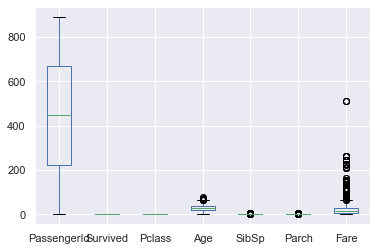

In [7]:
train_df.boxplot()

In [8]:
#train_df[['Age','Pclass']].boxplot()

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [10]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


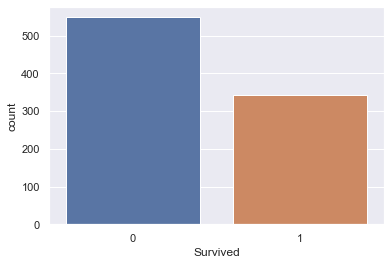

In [11]:
# How many died? Is it balanced?
sns.countplot(x='Survived', data = train_df)

In [12]:
# Percentage of survived
print(train_df.Survived.sum()/train_df.Survived.count())

0.3838383838383838


In [13]:
train_df.groupby(['Survived','Sex'])['Survived'].count()

Survived  Sex   
0         female     81
          male      468
1         female    233
          male      109
Name: Survived, dtype: int64

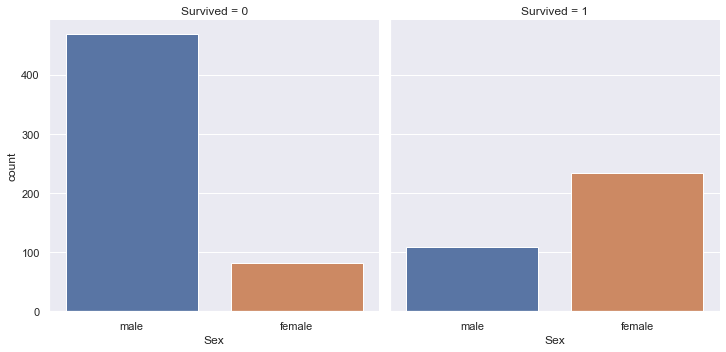

In [14]:
sns.catplot(x='Sex', col='Survived', kind='count', data=train_df);

In [15]:
print("% of women survived: " , train_df[train_df.Sex == 'female'].Survived.sum()/train_df[train_df.Sex == 'female'].Survived.count())
print("% of men survived:   " , train_df[train_df.Sex == 'male'].Survived.sum()/train_df[train_df.Sex == 'male'].Survived.count())

% of women survived:  0.7420382165605095
% of men survived:    0.18890814558058924


In [16]:
# Baseline model of women survived and mean died = 0.766 accuracy!

In [17]:
pd.crosstab(train_df.Pclass, train_df.Survived).style.background_gradient(cmap='autumn_r')
#, margins=True

Survived,0,1
Pclass,,
1,80,136
2,97,87
3,372,119


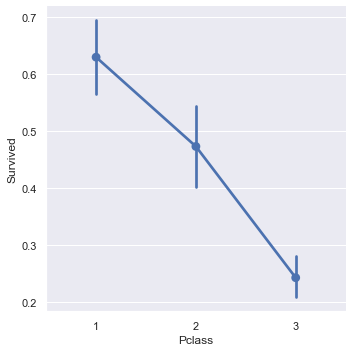

In [18]:
sns.catplot('Pclass','Survived', kind='point', data=train_df);

In [19]:
pd.crosstab([train_df.Sex, train_df.Survived], train_df.Pclass,margins=True).style.background_gradient(cmap='autumn_r')

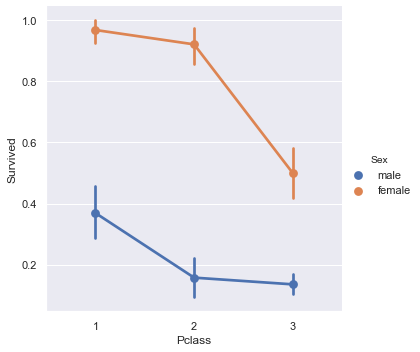

In [20]:
sns.catplot('Pclass','Survived',hue='Sex', kind='point', data=train_df);

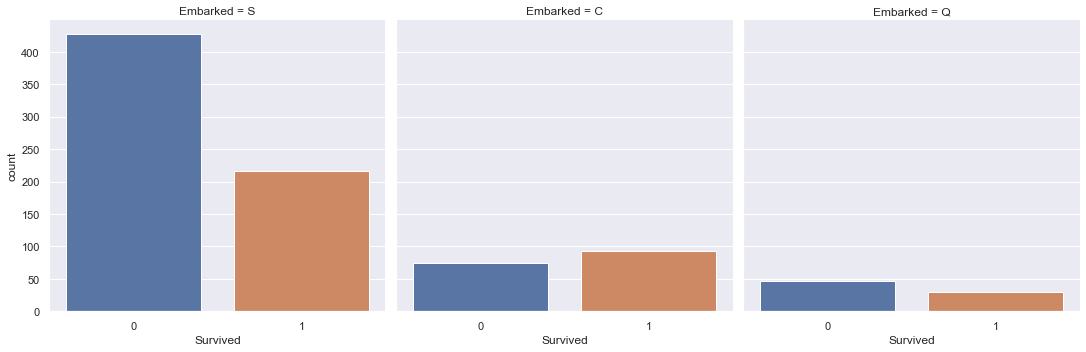

In [21]:
sns.catplot(x='Survived', col='Embarked', kind='count', data=train_df);

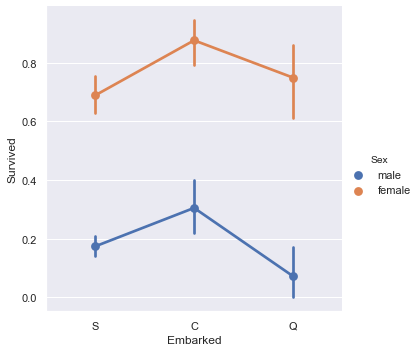

In [22]:
sns.catplot('Embarked','Survived', hue= 'Sex', kind='point', data=train_df);

$\textbf{Age: Continuous numerical to 8 bins}$ 

In [23]:
for df in [train_df, test_df]:
    df['Age_bin']=np.nan
    for i in range(8,0,-1):
        df.loc[ df['Age'] <= i*10, 'Age_bin'] = i

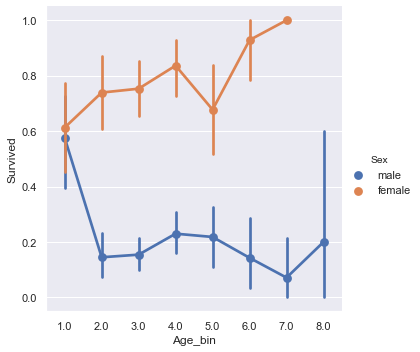

In [24]:
sns.catplot('Age_bin','Survived',hue='Sex',kind='point',data=train_df);

In [25]:
pd.crosstab([train_df.Sex, train_df.Survived], [train_df.Age_bin, train_df.Pclass], margins=True).style.background_gradient(cmap='autumn_r')

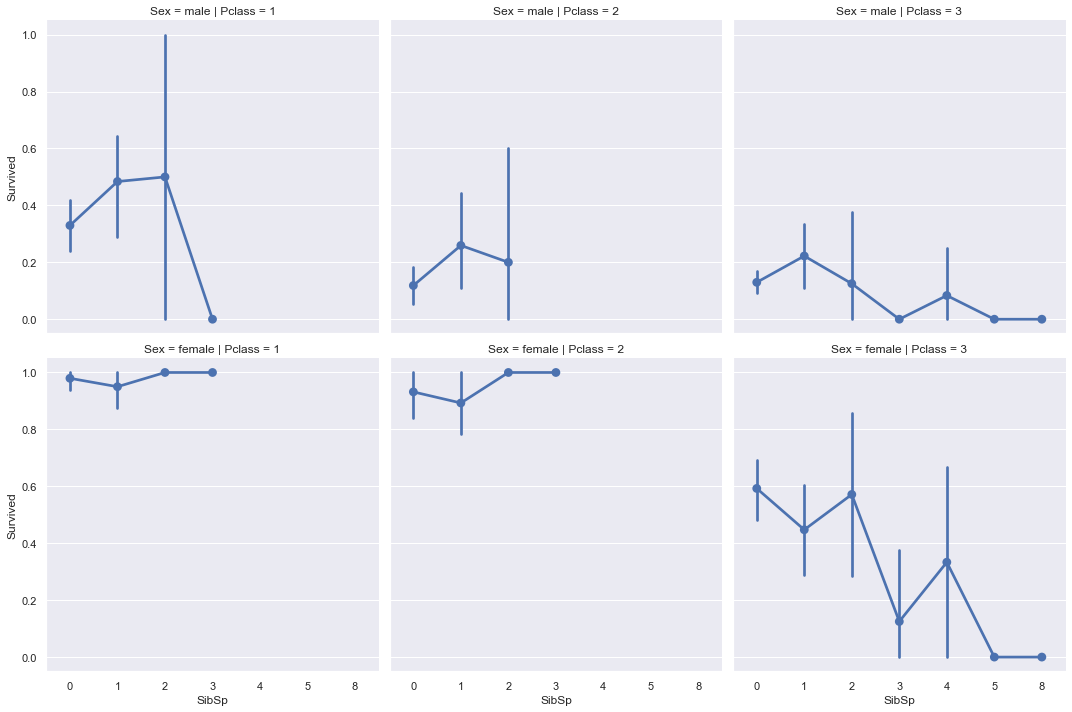

In [26]:
sns.catplot('SibSp','Survived', col='Pclass' , row = 'Sex', kind='point', data=train_df);

In [27]:
pd.crosstab([train_df.Sex, train_df.Survived], [train_df.SibSp, train_df.Pclass], margins=True).style.background_gradient(cmap='autumn_r')


$\textbf{Fare: continuous numerical to 12 bins}$

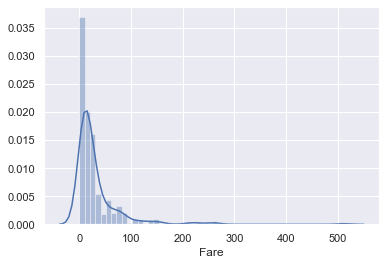

In [28]:
sns.distplot(train_df['Fare']);

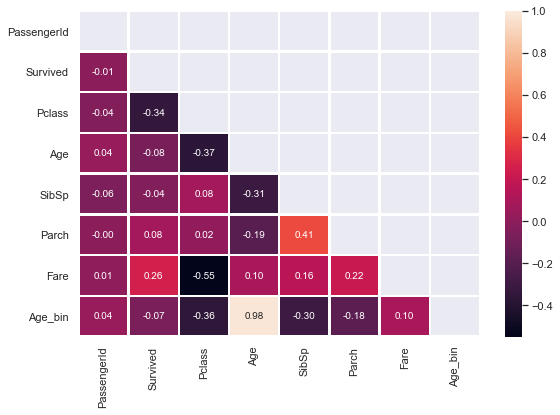

In [29]:
# Correlation matrix
corr = train_df.corr()
mask_ut = np.triu(np.ones(corr.shape)).astype(np.bool) # create a mask

f,ax = plt.subplots(figsize=(9,6))
sns.heatmap(corr, annot = True, linewidths=1.5 , fmt = '.2f',ax=ax, mask = mask_ut)
plt.show()

## Preprocessing

In [30]:
# First word is Last Name, so get it and make feature
train_df['LastName'] = train_df['Name'].str.split(',', expand=True)[0]
test_df['LastName'] = test_df['Name'].str.split(',', expand=True)[0]

# Get one "full" dataset
ds = pd.concat([train_df, test_df], sort = False)

In [31]:
#Checking survival rate by LastName
ds[['LastName', 'Survived']].groupby('LastName', as_index=False).mean().sort_values(by='Survived', ascending=False).head(10)

,LastName,Survived
435,Lehmann,1.0
287,Glynn,1.0
326,Hedman,1.0
325,Healy,1.0
323,Hays,1.0
322,Hawksford,1.0
320,Hassab,1.0
693,Ryerson,1.0
696,Saalfeld,1.0
312,Harder,1.0


In [32]:
#Creating two new features Family_died and FamilySuvived
sur = list()
died = list()

for index, row in ds.iterrows():
    s = ds[(ds['LastName']==row['LastName']) & (ds['Survived']==1)]
    d = ds[(ds['LastName']==row['LastName']) & (ds['Survived']==0)]
    s=len(s)
    if row['Survived'] == 1:
        s-=1
    d=len(d)
    if row['Survived'] == 0:
        d-=1
    sur.append(s)
    died.append(d)
ds['FamilySurvived'] = sur
ds['FamilyDied'] = died

In [33]:
# Dropping the Name and Last name
ds=ds.drop(['Name','LastName', 'PassengerId'], axis=1)

In [34]:
#Creating new feature: Familysize
ds['FamilySize'] = ds['SibSp'] + ds['Parch'] + 1
    
ds[['FamilySize', 'Survived']].groupby('FamilySize', as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


In [35]:
# Bin the family sizes
ds.loc[(ds['FamilySize']>1) & (ds['FamilySize']<=4), 'FamilySize'] = 0
ds.loc[(ds['FamilySize']==7) & (ds['FamilySize']==1), 'FamilySize'] = 1
ds.loc[(ds['FamilySize']==5) & (ds['FamilySize']==6), 'FamilySize'] = 2
ds.loc[(ds['FamilySize']>=8), 'FamilySize'] = 3

In [36]:
ds['IsAlone'] = 0
ds.loc[ds['FamilySize'] == 1, 'IsAlone'] = 1

In [37]:
ds.Fare.isnull().sum()

1

In [38]:
#Filling missing values by median - or should we actually do mode?
ds['Fare'].fillna(ds['Fare'].dropna().median(), inplace=True)

In [39]:
#Creating 4 groups of values by FareBand
ds['FareBand']=pd.qcut(ds['Fare'], 4)
ds[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 7.896]",0.197309
1,"(7.896, 14.454]",0.303571
2,"(14.454, 31.275]",0.441048
3,"(31.275, 512.329]",0.600000


In [40]:
#Mapping the Fare feature by FareBand
ds.loc[ds['Fare']<= 7.89, 'Fare']=0
ds.loc[(ds['Fare']>7.89) & (ds['Fare']<=14.454), 'Fare'] = 1
ds.loc[(ds['Fare']>14.454) & (ds['Fare']<=31.27), 'Fare'] = 2
ds.loc[ds['Fare']>31.27,'Fare'] = 3
ds['Fare'] = ds['Fare'].astype(int)
    
ds=ds.drop('FareBand', axis=1)

### Embarked

In [41]:
ds.Embarked.isnull().sum()

2

In [42]:
#Filling missing values by most common
freq_port = ds.Embarked.dropna().mode()[0]
ds['Embarked'] = ds['Embarked'].fillna(freq_port)

In [43]:
# Percentage of survivors per port
ds[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


In [44]:
# remap labels
ds['Embarked'] = ds['Embarked'].map({'S':0, 'C':1, 'Q':2}).astype(int)

### Ticket

In [45]:
Ticket = []
for i in list(ds.Ticket):
    if not i.isdigit() :
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0]) #Take prefix
    else:
        Ticket.append("X")
        
ds["Ticket"] = Ticket

In [46]:
label_encoder = preprocessing.LabelEncoder()
ds.Ticket= label_encoder.fit_transform(ds.Ticket) 

In [47]:
train = ds[ds['Survived'].notnull()]
test = ds[ds['Survived'].isnull()]
test = test.drop(['Survived'], axis=1)

### Rich / Poor by class

In [48]:
train[['Pclass', 'Survived', 'Sex']].groupby(['Pclass', 'Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Sex,Survived
0,1,female,0.968085
2,2,female,0.921053
4,3,female,0.500000
1,1,male,0.368852
3,2,male,0.157407
5,3,male,0.135447


In [49]:
#Creating features in both datasets 
train['rich_woman'] = 0
test['rich_woman'] = 0
train['poor_man'] = 0
test['poor_man'] = 0

In [50]:
train.loc[(train['Pclass']<=2) & (train['Sex']=='female'), 'rich_woman'] = 1
test.loc[(test['Pclass']<=2) & (test['Sex']=='female'), 'rich_woman'] = 1
train.loc[(train['Pclass']>=2) & (train['Sex']=='male'), 'poor_man'] = 1
test.loc[(test['Pclass']>=2) & (test['Sex']=='male'), 'poor_man'] = 1

### Cabin

In [51]:
# Indicate location of cabin in titanic
train["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in train['Cabin']])
test['Cabin'] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in test['Cabin']])

In [52]:
# Remap labels
cabin_dict={'X':0, 'C':1, 'E':2, 'G':3, 'D':4, 'A':5, 'B':6, 'F':7, 'T':6}
train['Cabin'] = train['Cabin'].map(cabin_dict)
test['Cabin'] = test['Cabin'].map(cabin_dict)

In [53]:
train = train.drop(['Ticket'], axis=1)
test = test.drop(['Ticket'], axis=1)

### Sex

In [54]:
# Remap sex
train['Sex'] = train['Sex'].map( {'female': 1, 'male': 0} )
test['Sex'] = test['Sex'].map( {'female': 1, 'male': 0} )

### Age

In [55]:
train.Age.isnull().sum(), test.Age.isnull().sum()

(177, 86)

In [56]:
index_NaN_age = list(train["Age"][train["Age"].isnull()].index)

for i in index_NaN_age :
    age_med = train["Age"].median()
    age_pred = train["Age"][((train['SibSp'] == train.iloc[i]["SibSp"]) & (train['Parch'] == train.iloc[i]["Parch"]) & (train['Pclass'] == train.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred) :
        train['Age'].iloc[i] = age_pred
    else :
        train['Age'].iloc[i] = age_med

index_NaN_age = list(test["Age"][test["Age"].isnull()].index)

for i in index_NaN_age :
    age_med = test["Age"].median()
    age_pred = test["Age"][((test['SibSp'] == test.iloc[i]["SibSp"]) & (test['Parch'] == test.iloc[i]["Parch"]) & (test['Pclass'] == test.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred) :
        test['Age'].iloc[i] = age_pred
    else :
        test['Age'].iloc[i] = age_med 

In [57]:
#deleting useless features
train = train.drop(['Parch', 'SibSp'], axis=1)
test = test.drop(['Parch', 'SibSp'], axis=1)

In [58]:
#Creating a new feature AgeBand
train['AgeBand'] = pd.cut(train['Age'], 5)
train[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(0.34, 16.336]",0.518868
1,"(16.336, 32.252]",0.340862
2,"(32.252, 48.168]",0.412844
3,"(48.168, 64.084]",0.434783
4,"(64.084, 80.0]",0.090909


In [59]:
combine2=[train, test]
for dataset in combine2:
    dataset.loc[dataset['Age']<=16, 'Age'] = 0
    dataset.loc[(dataset['Age']>16) & (dataset['Age']<32), 'Age'] = 1
    dataset.loc[(dataset['Age']>32) & (dataset['Age']<48), 'Age'] = 2
    dataset.loc[(dataset['Age']>48) & (dataset['Age']<64), 'Age'] = 3
    dataset.loc[dataset['Age']>64, 'Age'] = 4

train = train.drop(['AgeBand'], axis=1)

## Models

### Random Forests

In [60]:
X_train = train.drop(["Survived","Age_bin"], axis=1)
Y_train = train["Survived"]
X_test  = test.copy()
X_test.drop('Age_bin', axis=1, inplace=True)
X_train.shape, X_test.shape, Y_train.shape, test.shape

((891, 12), (418, 12), (891,), (418, 13))

In [61]:
random_forest = RandomForestClassifier()
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

92.37

In [62]:
rfc6 = RandomForestClassifier(n_estimators= 40, criterion= 'entropy', max_depth= 11, min_samples_split= 15,  min_samples_leaf= 9, 
                             max_features= 'sqrt', bootstrap= 'True', random_state=42)
rfc6.fit(X_train, Y_train)
Y_pred = rfc6.predict(X_test)
rfc6.score(X_train, Y_train)
acc_rfc6 = round(rfc6.score(X_train, Y_train) * 100, 2)
acc_rfc6

84.74

### Neural Networks

In [63]:
# Also get validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

In [92]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(12, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64,32)
        self.fc5 = nn.Linear(32,1)
        self.dropout = nn.Dropout(p=0)

    def forward(self, x):

        x = F.relu(self.fc1(x))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.dropout(F.relu(self.fc4(x)))
        x = self.fc5(x)
        #x = F.sigmoid(x)
        return x

net = Net()
net.float()

Net(
  (fc1): Linear(in_features=12, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0, inplace=False)
)

In [93]:
import torch.optim as optim

# Optimization and loss
#criterion = nn.BCELoss()
#criterion = nn.CrossEntropyLoss()
criterion = nn.BCEWithLogitsLoss()
#criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)

In [94]:
def val_acc():
    total = 0
    for i in range(len(X_val)):
        inputs = X_val.iloc[i,:].values
        labels = y_val.iloc[i]
        
        inputs = torch.tensor(inputs).float()
        labels = torch.tensor(labels).unsqueeze(0).float()
        
        outputs = F.sigmoid(net(inputs))
        preds = torch.round(outputs)
        
        if preds == labels:
            total += 1
            
    return total / len(X_val)

In [95]:
# Hyperparameters
num_epochs = 10
print(net.parameters)

<bound method Module.parameters of Net(
  (fc1): Linear(in_features=12, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0, inplace=False)
)>


In [96]:
# Main training loop

losses = []
accs   = []

for epoch in range(num_epochs):
    running_loss = 0.0
    
    for i in range(len(X_train)):
        # Empty the gradient buffer and get new data
        optimizer.zero_grad()
        inputs = X_train.iloc[i,:].values
        labels = y_train.iloc[i]
        
        # Turn into tensors
        inputs = torch.tensor(inputs, requires_grad=True)
        inputs = inputs.float()
        labels = torch.tensor(labels)
        labels = labels.unsqueeze(0).float()
        
        # Forward pass and loss calculation
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if i % 10 == 0:
            val_acc_100 = val_acc()
            #print(val_acc)
            accs.append(val_acc_100)
        
        #print(net.fc1.weight)
#         if i % 100 == 99:    # print every 100 examples
#             print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
#             running_loss = 0.0
            
print('Finished Training')
print("Validation Accuracy: ", val_acc())

Finished Training
Validation Accuracy:  0.8324022346368715


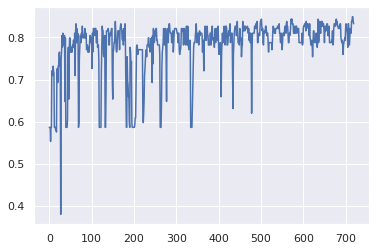

In [97]:
plt.plot(accs)

In [103]:
# Fetch predictions from NN
def fetch_preds():
    final_preds = []
    for i in range(len(X_test)):
        inputs = X_test.iloc[i,:].values
        inputs = torch.tensor(inputs).float()
        
        outputs = F.sigmoid(net(inputs))
        preds = torch.round(outputs)
        
        final_preds.append(preds)
        
    return np.array(final_preds)

In [104]:
Y_pred = fetch_preds()

## Submission

In [63]:
output = pd.DataFrame({'PassengerId': PassengerId, 'Survived': Y_pred.astype(int)})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
